In [99]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

import json
import numpy as np
import pandas as pd
from tqdm import tqdm

import os
import matplotlib.pyplot as plt

In [100]:
df = pd.read_csv("train_data/train_x.csv")
df.shape

(2907214, 13)

In [101]:
# Metal GPU support
if torch.backends.mps.is_available():
    device = torch.device("mps")  # "mps" stands for Metal Performance Shaders (Apple's Metal API)
    print("Using Apple Metal GPU.")
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("Using CPU.")

Using Apple Metal GPU.


## Dataset

In [102]:
from scipy.ndimage import gaussian_filter1d


def gaussian_smoothing(chroma_features, sigma=1):
    """
    Apply Gaussian smoothing to chroma features.
    :param chroma_features: numpy array of shape (num_samples, num_features)
    :param sigma: standard deviation for the Gaussian kernel
    :return: Smoothed chroma features
    """
    smoothed_features = np.copy(chroma_features)
    for i in range(chroma_features.shape[1]):  # Apply Gaussian smoothing to each chroma feature
        smoothed_features[:, i] = gaussian_filter1d(chroma_features[:, i], sigma=sigma)
    return smoothed_features


class Music_Dataset(Dataset):
    def __init__(self, x_csv_path, y_csv_path, window_size, step_size):
        """
        Args:
            data_path (str): Path to the CSV file containing the chroma features and labels.
            window_size (int): The length of each sequence (number of chroma features in a window).
            step_size (int): The number of steps the window moves (controls overlap).
        """
        # read in X, Y values
        self.data = pd.read_csv(x_csv_path)
        self.labels = pd.read_csv(y_csv_path)
        # process csv file content
        self.chroma_features = self.data.values
        # apply smoothing
        self.chroma_features = gaussian_smoothing(self.chroma_features, sigma=1)
        # parameters
        self.window_size = window_size
        self.step_size = step_size

    def __len__(self):
        # total number of windows spanning the dataset
        return (len(self.chroma_features) - self.window_size) // self.step_size + 1

    def __getitem__(self, idx):
        # find window start and end index
        start_idx = idx * self.step_size
        end_idx = start_idx + self.window_size
        mid_idx = start_idx + (self.window_size // 2)
        # get both the chroma features and the label
        window_chroma = self.chroma_features[start_idx:end_idx]
        window_label = self.labels.iloc[mid_idx, 0]
        # convert to tensors
        window_chroma = torch.tensor(window_chroma, dtype=torch.float32)
        # Add channel dimension: (1, window_size, 13)
        window_chroma = window_chroma.unsqueeze(0)  # Adds the channel dimension
        window_label = torch.tensor(window_label, dtype=torch.long)
        return window_chroma, window_label

## Model

In [114]:
class CNN_Model(nn.Module):
    def __init__(self, window_size, num_classes):
        super(CNN_Model, self).__init__()
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2, ceil_mode=True)
        )
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=(1, 1)),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=(2, 2), stride=2,  ceil_mode=True)
        )
        flattened_size = 64 * (window_size // 4) * (13 // 4 + (13 % 4 > 0))
        self.fc1 = nn.Linear(flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1) # out.size(0) gives the batch size. output will become (batch_size, flattened_size)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

## training loop

Learning Rate finder

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.79E-04


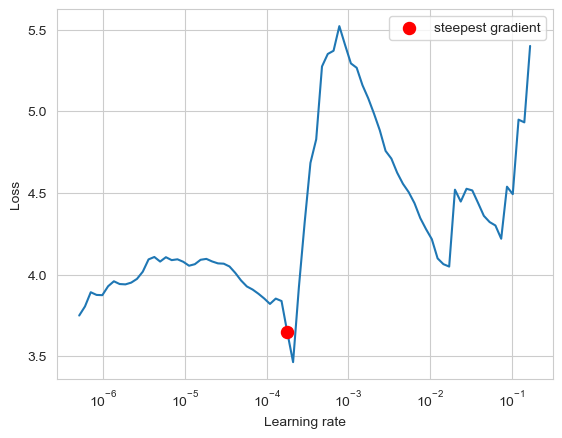

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.54E-05


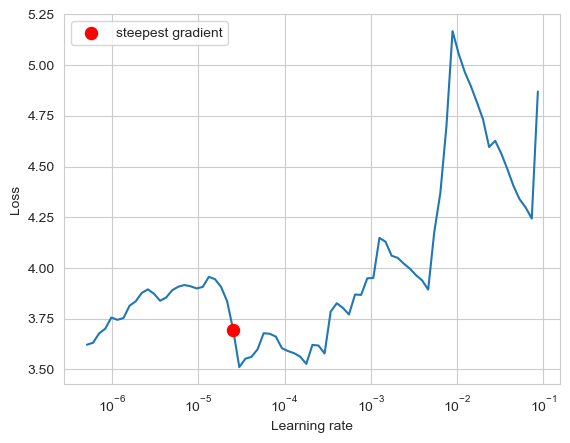

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.05E-02


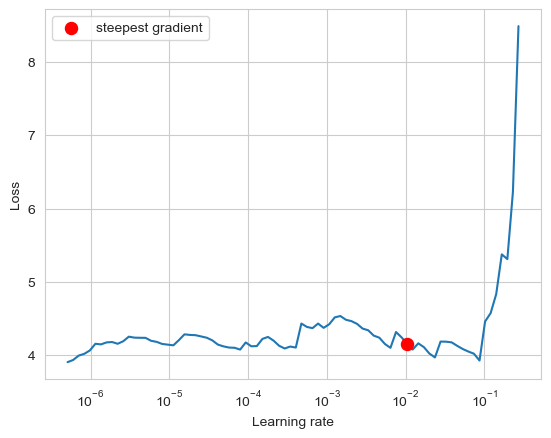

In [115]:
from torch_lr_finder import LRFinder

window_sizes = [48, 64, 72]
batch_size = 128
num_classes = 36

for win_size in window_sizes:
    step_size = win_size // 2   # half overlapping windows

    # load datasets
    train_X_path = os.path.join("train_data", "train_x.csv")
    train_y_path = os.path.join("train_data", "train_y.csv")
    train_dataset = Music_Dataset(train_X_path, train_y_path, win_size, step_size)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

    model = CNN_Model(window_size=win_size, num_classes=num_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-7)
    criterion = torch.nn.CrossEntropyLoss()

    lr_finder = LRFinder(model, optimizer, criterion, device="mps")
    lr_finder.range_test(train_dataloader, end_lr=1, num_iter=100)
    lr_finder.plot()  # Plot to find the optimal learning rate

Epoch 1/10: 100%|██████████| 947/947 [00:18<00:00, 51.28batch/s, loss=2.09]


val loss=1.798974375218009; val accuracy=41.696887277123%


Epoch 2/10: 100%|██████████| 947/947 [00:17<00:00, 52.84batch/s, loss=1.48]


val loss=1.7169177958354858; val accuracy=45.66334239951647%


Epoch 3/10: 100%|██████████| 947/947 [00:18<00:00, 51.29batch/s, loss=1.5] 


val loss=1.7387007054499382; val accuracy=43.73677848292535%


Epoch 4/10: 100%|██████████| 947/947 [00:18<00:00, 51.27batch/s, loss=1.22] 


val loss=1.6796637066608466; val accuracy=46.09398609851919%


Epoch 5/10: 100%|██████████| 947/947 [00:18<00:00, 51.35batch/s, loss=1.29] 


val loss=1.680763005922382; val accuracy=46.324418253248716%


Epoch 6/10: 100%|██████████| 947/947 [00:18<00:00, 52.04batch/s, loss=1.21] 


val loss=1.7079746160242293; val accuracy=45.20625566636446%


Epoch 7/10: 100%|██████████| 947/947 [00:18<00:00, 52.17batch/s, loss=1.32] 


val loss=1.7073877747508064; val accuracy=44.13720157147174%


Epoch 8/10: 100%|██████████| 947/947 [00:17<00:00, 53.69batch/s, loss=1.24] 


val loss=1.6504386964339566; val accuracy=47.627682079178%


Epoch 9/10: 100%|██████████| 947/947 [00:17<00:00, 53.26batch/s, loss=1.49] 


val loss=1.6928598296239181; val accuracy=45.916440012088245%


Epoch 10/10: 100%|██████████| 947/947 [00:18<00:00, 52.14batch/s, loss=0.881]


val loss=1.6641278278424545; val accuracy=46.78528256270776%


Epoch 1/10: 100%|██████████| 710/710 [00:15<00:00, 44.83batch/s, loss=1.45]


val loss=1.7995166308604753; val accuracy=41.45764077767704%


Epoch 2/10: 100%|██████████| 710/710 [00:15<00:00, 46.25batch/s, loss=1.06]


val loss=1.7470808575550716; val accuracy=45.3409892213156%


Epoch 3/10: 100%|██████████| 710/710 [00:15<00:00, 45.69batch/s, loss=1.4] 


val loss=1.7041933032182546; val accuracy=45.270474463584165%


Epoch 4/10: 100%|██████████| 710/710 [00:15<00:00, 46.36batch/s, loss=1.22] 


val loss=1.6869942725468905; val accuracy=45.87488667271079%


Epoch 5/10: 100%|██████████| 710/710 [00:15<00:00, 46.21batch/s, loss=1.17] 


val loss=1.6811729891177936; val accuracy=46.99808602800443%


Epoch 6/10: 100%|██████████| 710/710 [00:17<00:00, 40.76batch/s, loss=0.97] 


val loss=1.692645944463901; val accuracy=45.35106275813438%


Epoch 7/10: 100%|██████████| 710/710 [00:15<00:00, 44.38batch/s, loss=1.07] 


val loss=1.6803320210713606; val accuracy=47.1441523118767%


Epoch 8/10: 100%|██████████| 710/710 [00:16<00:00, 44.23batch/s, loss=0.982]


val loss=1.6547945160896351; val accuracy=47.19451999597059%


Epoch 9/10: 100%|██████████| 710/710 [00:16<00:00, 44.11batch/s, loss=1.32] 


val loss=1.6429383745178199; val accuracy=48.59977838218999%


Epoch 10/10: 100%|██████████| 710/710 [00:15<00:00, 45.68batch/s, loss=0.57] 


val loss=1.6913480218022297; val accuracy=45.955474967261004%


Epoch 1/10: 100%|██████████| 631/631 [00:15<00:00, 41.75batch/s, loss=1.72]


val loss=1.8358265312685482; val accuracy=40.3014676715589%


Epoch 2/10: 100%|██████████| 631/631 [00:15<00:00, 41.33batch/s, loss=1.42]


val loss=1.737005457929943; val accuracy=45.29381764605882%


Epoch 3/10: 100%|██████████| 631/631 [00:15<00:00, 41.73batch/s, loss=1.3] 


val loss=1.7090839687464894; val accuracy=46.80682268940897%


Epoch 4/10: 100%|██████████| 631/631 [00:15<00:00, 41.93batch/s, loss=1.33] 


val loss=1.705505465251812; val accuracy=46.56882189607299%


Epoch 5/10: 100%|██████████| 631/631 [04:16<00:00,  2.46batch/s, loss=1.26]  


val loss=1.7351860287396803; val accuracy=45.63948546495155%


Epoch 6/10: 100%|██████████| 631/631 [15:56<00:00,  1.52s/batch, loss=1.17]   


val loss=1.6818468467048977; val accuracy=47.34515781719272%


Epoch 7/10: 100%|██████████| 631/631 [00:14<00:00, 42.77batch/s, loss=0.997]


val loss=1.6750399254370427; val accuracy=47.373491244970815%


Epoch 8/10: 100%|██████████| 631/631 [00:14<00:00, 43.82batch/s, loss=1.27] 


val loss=1.7304203173388606; val accuracy=44.94814982716609%


Epoch 9/10: 100%|██████████| 631/631 [00:14<00:00, 43.61batch/s, loss=1.05] 


val loss=1.6800611515839894; val accuracy=47.38482461608206%


Epoch 10/10: 100%|██████████| 631/631 [00:14<00:00, 44.25batch/s, loss=1.14] 


val loss=1.6452014826346135; val accuracy=48.94316314387714%


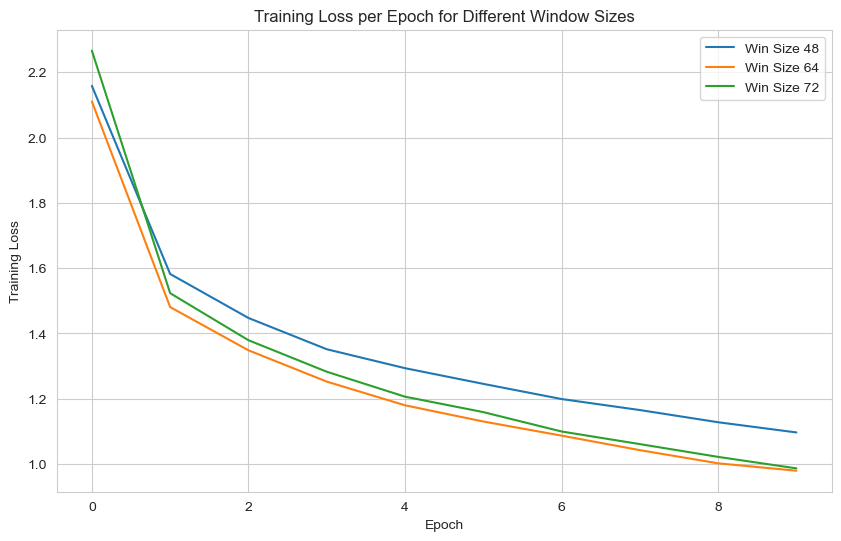

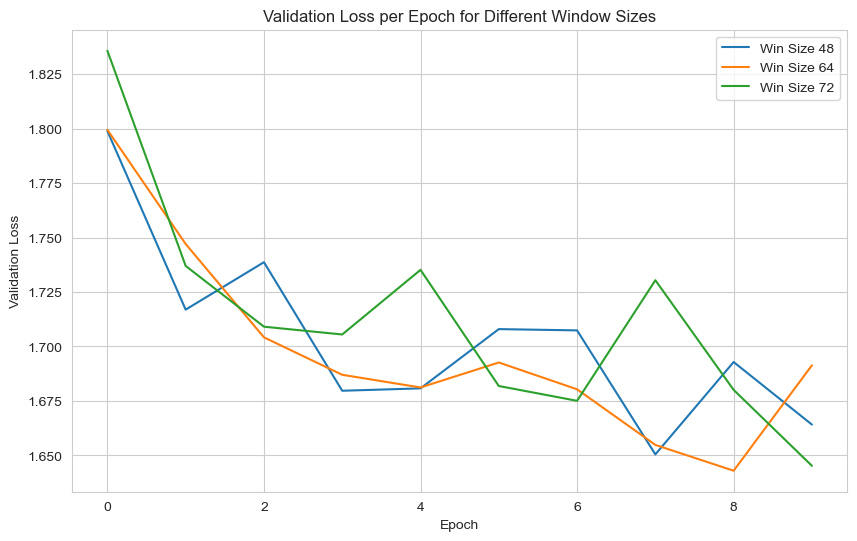

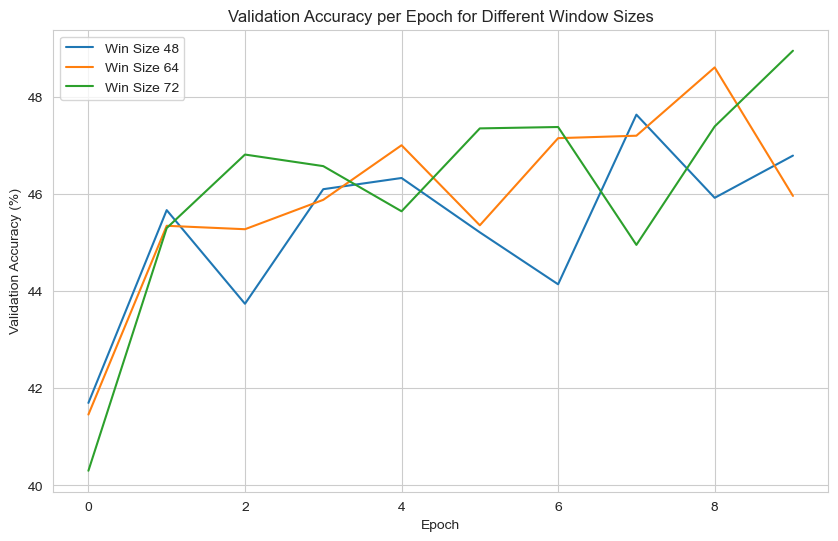

In [124]:
from torch.utils.data import WeightedRandomSampler

# Hyperparameters
window_sizes = [48, 64, 72]
batch_size = 128
num_epochs = 10
learning_rates = [0.0001, 0.0001, 0.0001]
# using small portion of whole dataset
fraction = 1
num_classes = 36

results = {}

for j, win_size in enumerate(window_sizes):
    step_size = win_size // 2   # half overlapping windows

    # load datasets
    train_X_path = os.path.join("train_data", "train_x.csv")
    train_y_path = os.path.join("train_data", "train_y.csv")
    train_dataset = Music_Dataset(train_X_path, train_y_path, win_size, step_size)

    # Random weight sampling to make up for uneven dataset labels
    all_labels = [train_dataset[idx][1].item() for idx in range(len(train_dataset))]
    labels_counts = np.bincount(all_labels)     # the value represents the number of occurrence for label=idx
    class_weights = 1.0 / (labels_counts + 1e-6)
    sample_weights = [class_weights[label] for label in all_labels]    # assign weights to all labels in the training data
    sampler = WeightedRandomSampler(
        sample_weights, num_samples=len(sample_weights), replacement=True
    )
    # training dataloader with sampler applied
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, shuffle=False)

    val_X_path = os.path.join("train_data", "val_x.csv")
    val_y_path = os.path.join("train_data", "val_y.csv")
    val_dataset = Music_Dataset(val_X_path, val_y_path, win_size, step_size)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_X_path = os.path.join("train_data", "test_x.csv")
    test_y_path = os.path.join("train_data", "test_y.csv")
    test_dataset = Music_Dataset(test_X_path, test_y_path, win_size, step_size)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # initialize model, loss function, optimizer
    model = CNN_Model(window_size=win_size, num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rates[j], weight_decay=1e-5)

    # record losses
    train_losses_cross_epoch = []
    val_losses_cross_epoch = []
    val_accuracy_cross_epoch = []

    # train loop
    for epoch in range(num_epochs):
        train_loss_per_epoch = []
        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for i, (win_chroma, win_label) in enumerate(train_dataloader):
                X = win_chroma.to(device)
                Y = win_label.to(device)

                optimizer.zero_grad()
                prediction = model(X)
                loss = criterion(prediction, Y)
                loss.backward()
                optimizer.step()

                # update progress bar
                pbar.set_postfix({"loss": loss.item()})     # display current loss
                pbar.update(1)      # advance progress bar by 1 batch

                # train loss per batch
                train_loss_per_epoch.append(loss.item())
        # calculate train loss for each epoch
        mean_train_loss_per_epoch = np.mean(train_loss_per_epoch)
        train_losses_cross_epoch.append(mean_train_loss_per_epoch)

        # evaluation
        model.eval()
        val_losses = []
        num_correct_per_epoch = 0
        num_total_per_epoch = 0
        with torch.no_grad():
            for i, (val_win_chroma, val_win_label) in enumerate(val_dataloader):
                val_X = val_win_chroma.to(device)
                val_Y = val_win_label.to(device)

                val_predictions = model(val_X)
                val_loss = criterion(val_predictions, val_Y).to('cpu')

                # val loss per batch
                val_losses.append(val_loss.item())

                # val accuracy per batch
                _, predicted_class = torch.max(val_predictions, 1)
                num_correct = (predicted_class == val_Y).sum().item()
                num_total_per_batch = val_Y.size(0)
                batch_accuracy = num_correct / num_total_per_batch

                # accumulate correct and total predictions from each batch
                num_correct_per_epoch += num_correct
                num_total_per_epoch += num_total_per_batch

        # calculate evaluation loss for each epoch
        mean_val_loss_per_epoch = np.mean(val_losses)
        val_losses_cross_epoch.append(mean_val_loss_per_epoch)

        # calculate accuracy per eepoch
        val_accuracy = 100 * num_correct_per_epoch / num_total_per_epoch
        val_accuracy_cross_epoch.append(val_accuracy)

        # display loss & accuracy in progress bar
        print(f"val loss={mean_val_loss_per_epoch}; val accuracy={val_accuracy}%")
        model.train()

    # save loss and accuracy
    results[win_size] = {
        "train_losses": train_losses_cross_epoch,
        "val_losses": val_losses_cross_epoch,
        "val_accuracies": val_accuracy_cross_epoch
    }

# Get all window sizes
window_sizes = list(results.keys())

# 1. Plot for Training Loss
plt.figure(figsize=(10, 6))
for win_size in window_sizes:
    plt.plot(results[win_size]["train_losses"], label=f"Win Size {win_size}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch for Different Window Sizes")
plt.legend()
plt.show()

# 2. Plot for Validation Loss
plt.figure(figsize=(10, 6))
for win_size in window_sizes:
    plt.plot(results[win_size]["val_losses"], label=f"Win Size {win_size}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Epoch for Different Window Sizes")
plt.legend()
plt.show()

# 3. Plot for Validation Accuracy
plt.figure(figsize=(10, 6))
for win_size in window_sizes:
    plt.plot(results[win_size]["val_accuracies"], label=f"Win Size {win_size}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy per Epoch for Different Window Sizes")
plt.legend()
plt.show()